In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, Input
import tensorflow as tf
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'

class MyDataset(tf.data.Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
class YourCustomDataset(tf.keras.utils.Sequence):
    def __init__(self, *args, **kwargs):
        super().__init__(**kwargs)

In [ ]:
def get_subfolders_and_image_counts(directory):
    subfolders = {}
    for subdir, dirs, files in os.walk(directory):
        if dirs:
            for folder in dirs:
                folder_path = os.path.join(subdir, folder)
                num_images = len([file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))])
                subfolders[folder] = num_images
    return subfolders

train_subfolders = get_subfolders_and_image_counts('train')
test_subfolders = get_subfolders_and_image_counts('test')

In [3]:
print("Training Subfolders and Image Counts:")
for folder, count in train_subfolders.items():
    print(f"{folder}: {count} images")

print("\nTest Subfolders and Image Counts:")
for folder, count in test_subfolders.items():
    print(f"{folder}: {count} images")

Training Subfolders and Image Counts:
surprise: 3171 images
fear: 4097 images
angry: 3995 images
neutral: 4965 images
sad: 4830 images
disgust: 436 images
happy: 7215 images

Test Subfolders and Image Counts:
surprise: 831 images
fear: 1024 images
angry: 958 images
neutral: 1233 images
sad: 1247 images
disgust: 111 images
happy: 1774 images


In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
train_counts = {
    'Category': ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy'],
    'Count': [3171, 4097, 3995, 4965, 4830, 436, 7215]
}

test_counts = {
    'Category': ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy'],
    'Count': [831, 1024, 958, 1233, 1247, 111, 1774]
}

df_train = pd.DataFrame(train_counts)
df_test = pd.DataFrame(test_counts)
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'pie'}, {'type':'pie'}]])

fig.add_trace(go.Pie(
    labels=df_train['Category'],
    values=df_train['Count'],
    name='Training Dataset',
    hoverinfo='label+percent',
    title='Training Dataset Distribution'
), row=1, col=1)

fig.add_trace(go.Pie(
    labels=df_test['Category'],
    values=df_test['Count'],
    name='Test Dataset',
    hoverinfo='label+percent',
    title='Test Dataset Distribution'
), row=1, col=2)

fig.update_layout(title_text='Dataset Distribution', title_x=0.5)

fig.show()

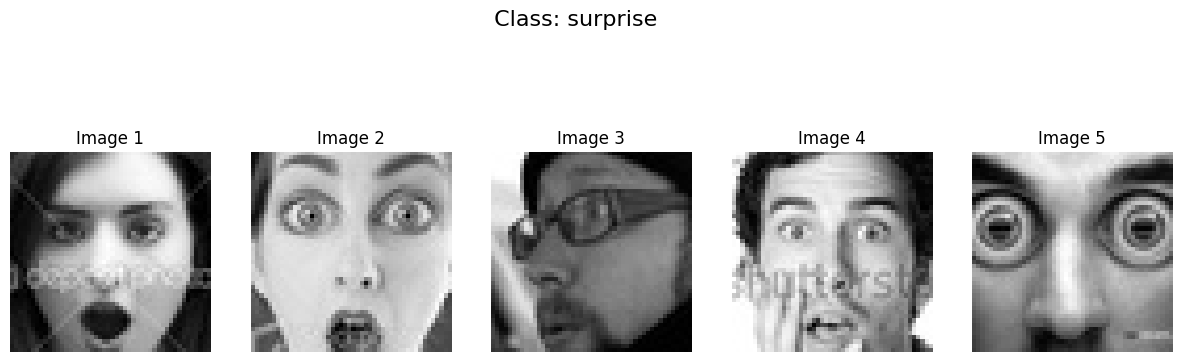

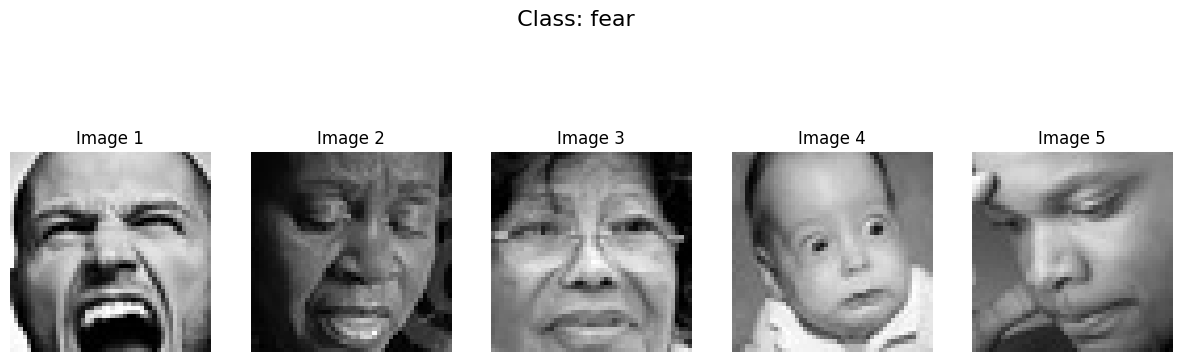

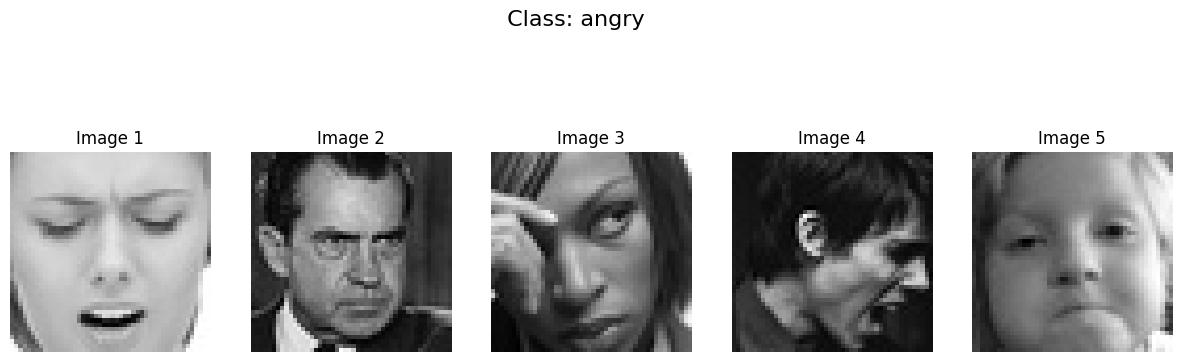

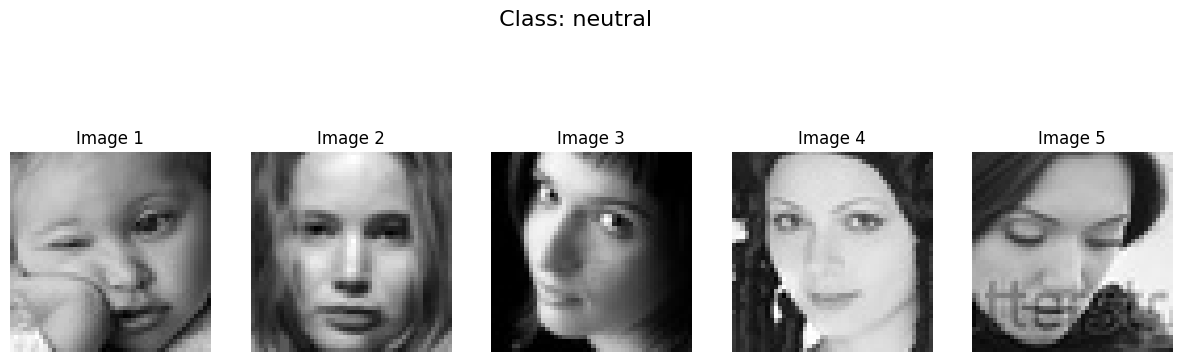

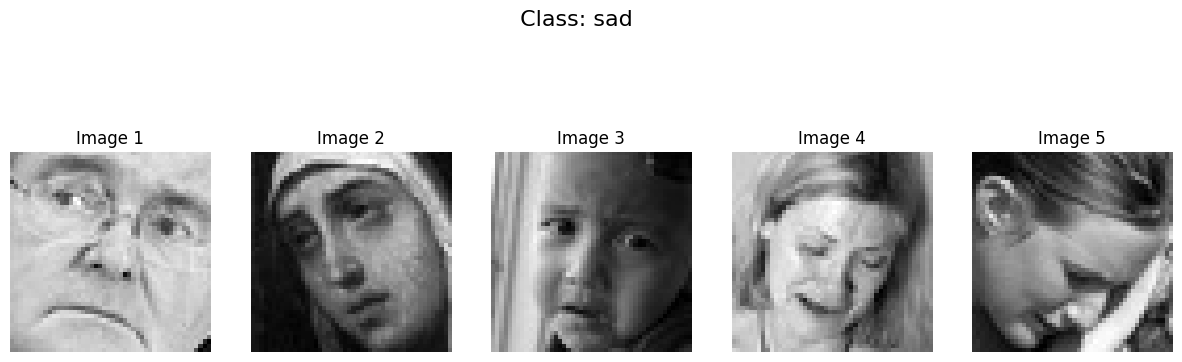

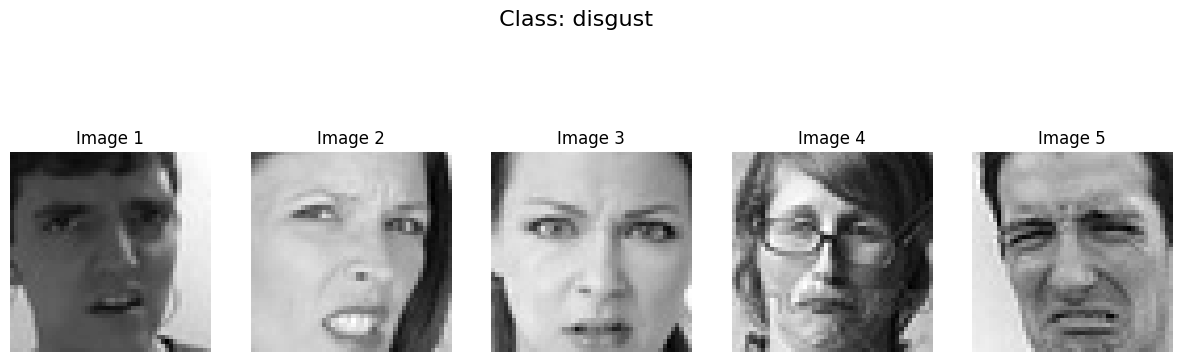

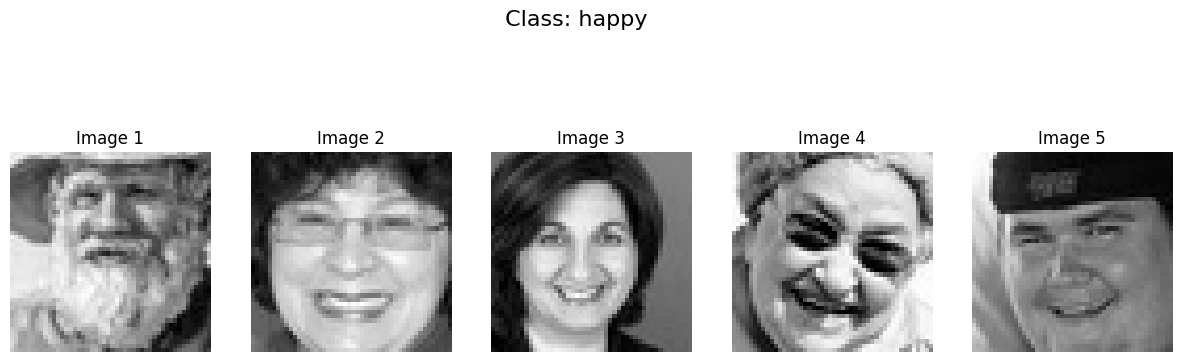

In [5]:
directory = '/kaggle/input/fer2013/train'
folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    
for folder in folders:
        folder_path = os.path.join(directory, folder)
        image_files = os.listdir(folder_path)[:5]  
        
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        fig.suptitle(f" Class: {folder}", fontsize=16)
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')  
            axes[i].set_title(f"Image {i+1}")
        
        plt.show()

In [6]:
def add_noise(image):  
      
    noise_type = tf.random.uniform([], 0, 1)  
    
    if noise_type < 0.4:
        noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.03)  
        image = image + noise  
    elif noise_type < 0.7:   
        mask = tf.random.uniform(tf.shape(image)) < 0.05  
        noise = tf.random.uniform(tf.shape(image))  
        image = tf.where(mask, noise, image)  
    
    return tf.clip_by_value(image, 0.0, 1.0) 


def logarithmic_transform(image):  
    # Ensure pixel values are within [0, 1]  
    image = tf.clip_by_value(image, 0.0, 1.0)  
    # Apply logarithmic transformation  
    image = tf.math.log1p(image)  # Computes natural log (ln(1 + image))  
    # Normalize to keep values within [0, 1]  
    image = image / tf.math.log(2.0)  
    return image

def gamma_transform(image, gamma=1.0):  
    """Apply gamma correction to the image."""  
    # Ensure pixel values are within [0, 1]  
    image = tf.clip_by_value(image, 0.0, 1.0)  
    # Apply gamma correction  
    image = tf.math.pow(image, gamma)  
    return image


def advanced_preprocessing(image): 
    if tf.random.uniform([]) > 0.5:  
        image = logarithmic_transform(image)  

    # Randomly apply gamma transformation with a random gamma value  
    if tf.random.uniform([]) > 0.5:  
        gamma = tf.random.uniform([], 0.8, 1.2)  # Gamma values between 0.8 and 1.2  
        image = gamma_transform(image, gamma)  
    if tf.random.uniform([]) > 0.7:  
        image = add_noise(image) 
        
    return tf.clip_by_value(image, 0.0, 1.0)

In [7]:
filepaths = []
labels = []

folds = os.listdir(r'/kaggle/input/fer2013/train')
for fold in folds:
    foldpath = os.path.join(r'/kaggle/input/fer2013/train', fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

,filepaths,labels
0,/kaggle/input/fer2013/train/surprise/Training_...,surprise
1,/kaggle/input/fer2013/train/surprise/Training_...,surprise
2,/kaggle/input/fer2013/train/surprise/Training_...,surprise
3,/kaggle/input/fer2013/train/surprise/Training_...,surprise
4,/kaggle/input/fer2013/train/surprise/Training_...,surprise
...,...,...
28704,/kaggle/input/fer2013/train/happy/Training_188...,happy
28705,/kaggle/input/fer2013/train/happy/Training_165...,happy
28706,/kaggle/input/fer2013/train/happy/Training_108...,happy
28707,/kaggle/input/fer2013/train/happy/Training_304...,happy


In [8]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df[['filepaths']], train_df['labels'])

balanced_train_df = pd.DataFrame({
    'filepaths': X_resampled['filepaths'],
    'labels': y_resampled
})
balanced_train_df

,filepaths,labels
0,/kaggle/input/fer2013/train/surprise/Training_...,surprise
1,/kaggle/input/fer2013/train/surprise/Training_...,surprise
2,/kaggle/input/fer2013/train/surprise/Training_...,surprise
3,/kaggle/input/fer2013/train/surprise/Training_...,surprise
4,/kaggle/input/fer2013/train/surprise/Training_...,surprise
...,...,...
50500,/kaggle/input/fer2013/train/surprise/Training_...,surprise
50501,/kaggle/input/fer2013/train/surprise/Training_...,surprise
50502,/kaggle/input/fer2013/train/surprise/Training_...,surprise
50503,/kaggle/input/fer2013/train/surprise/Training_...,surprise


In [9]:
filepaths = []
labels = []

folds = os.listdir(r'/kaggle/input/fer2013/test')
for fold in folds:
    foldpath = os.path.join(r'/kaggle/input/fer2013/test', fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)
ts_df

,filepaths,labels
0,/kaggle/input/fer2013/test/surprise/PublicTest...,surprise
1,/kaggle/input/fer2013/test/surprise/PrivateTes...,surprise
2,/kaggle/input/fer2013/test/surprise/PrivateTes...,surprise
3,/kaggle/input/fer2013/test/surprise/PublicTest...,surprise
4,/kaggle/input/fer2013/test/surprise/PrivateTes...,surprise
...,...,...
7173,/kaggle/input/fer2013/test/happy/PublicTest_13...,happy
7174,/kaggle/input/fer2013/test/happy/PublicTest_70...,happy
7175,/kaggle/input/fer2013/test/happy/PublicTest_24...,happy
7176,/kaggle/input/fer2013/test/happy/PrivateTest_7...,happy


In [10]:
train_df , val_df = train_test_split(balanced_train_df , test_size = 0.2 , random_state = 42 , shuffle = True)

In [11]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

In [12]:
train_gen = tr_gen.flow_from_dataframe(balanced_train_df, x_col= 'filepaths', y_col= 'labels', target_size= (224, 224), class_mode='categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= 100)

Found 50505 validated image filenames belonging to 7 classes.


In [13]:
valid_gen = ts_gen.flow_from_dataframe(val_df, x_col= 'filepaths', y_col= 'labels', target_size= (224,224), class_mode='categorical',
                                     color_mode= 'rgb', shuffle= True, batch_size= 100)

Found 10101 validated image filenames belonging to 7 classes.


In [14]:
test_gen = ts_gen.flow_from_dataframe(ts_df, x_col= 'filepaths', y_col= 'labels', target_size= (224,224), class_mode='categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= 100)

Found 7178 validated image filenames belonging to 7 classes.


In [15]:
def residual_block(input_tensor, filters, kernel_size=3, stride=1):
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(input_tensor) if stride != 1 else input_tensor
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output

x = GlobalAveragePooling2D()(x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [17]:
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

emotion_output = Dense(7, activation='softmax', name='emotion_output')(x)

model = Model(inputs=base_model.input, outputs=emotion_output)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,383,495 (100.65 MB)

 Trainable params: 26,326,535 (100.43 MB)

 Non-trainable params: 56,960 (222.50 KB)

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)

In [19]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=50,
                    batch_size=32,
                    callbacks=[ 
                        EarlyStopping(monitor='val_loss', patience=10),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
                        ModelCheckpoint(filepath='best_complex_model.keras', save_best_only=True, monitor='val_loss')
                    ])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



506/506 ━━━━━━━━━━━━━━━━━━━━ 552s 969ms/step - accuracy: 0.2790 - loss: 2.0112 - val_accuracy: 0.2709 - val_loss: 2.3170 - learning_rate: 0.0010
Epoch 2/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 489s 963ms/step - accuracy: 0.5604 - loss: 1.1587 - val_accuracy: 0.5890 - val_loss: 1.0785 - learning_rate: 0.0010
Epoch 3/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 487s 958ms/step - accuracy: 0.6702 - loss: 0.8908 - val_accuracy: 0.2952 - val_loss: 2.0523 - learning_rate: 0.0010
Epoch 4/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 487s 958ms/step - accuracy: 0.7284 - loss: 0.7572 - val_accuracy: 0.5346 - val_loss: 1.5194 - learning_rate: 0.0010
Epoch 5/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 489s 963ms/step - accuracy: 0.7812 - loss: 0.6344 - val_accuracy: 0.6866 - val_loss: 0.8980 - learning_rate: 0.0010
Epoch 6/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 488s 961ms/step - accuracy: 0.8297 - loss: 0.5079 - val_accuracy: 0.7259 - val_loss: 0.8119 - learning_rate: 0.0010
Epoch 7/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 485s 956ms/step - accuracy: 0.8818 

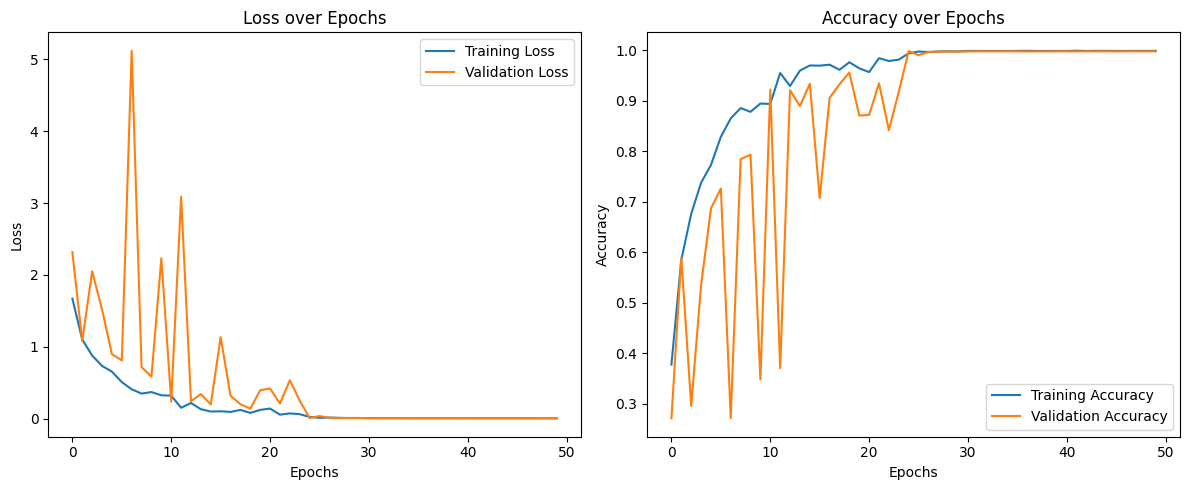

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
loss, accuracy = model.evaluate(test_gen)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 956ms/step - accuracy: 0.6126 - loss: 2.7066
Test Accuracy: 62.48%


In [22]:
pred = model.predict(test_gen)
pred = np.argmax(pred, axis=1)

72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 287ms/step


In [23]:
pred_df=ts_df.copy()
labels={}
for l,v in test_gen.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

              precision    recall  f1-score   support

       angry       0.55      0.52      0.53       958
     disgust       0.77      0.43      0.55       111
        fear       0.49      0.46      0.47      1024
       happy       0.81      0.83      0.82      1774
     neutral       0.56      0.58      0.57      1233
         sad       0.47      0.53      0.50      1247
    surprise       0.79      0.77      0.78       831

    accuracy                           0.62      7178
   macro avg       0.64      0.59      0.60      7178
weighted avg       0.63      0.62      0.62      7178



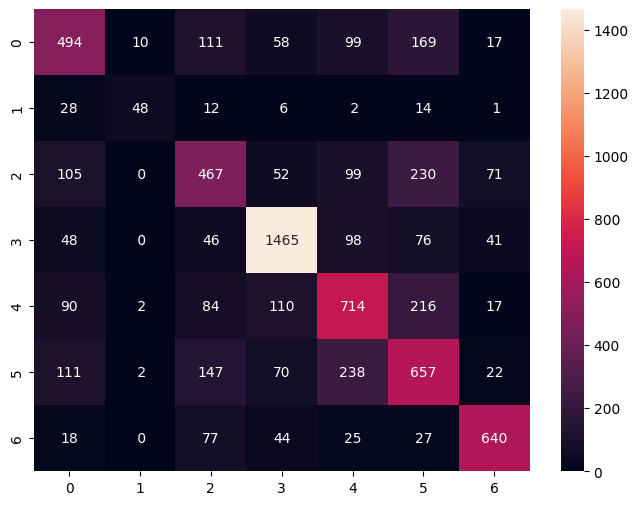

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['labels'],pred_df['pred']), annot=True, fmt='2d')
print(classification_report(pred_df['labels'],pred_df['pred']))

In [25]:
model.save("/kaggle/working/my_model.h5")

from IPython.display import FileLink
FileLink(r'/kaggle/working/my_model.h5')

/kaggle/working/my_model.h5